Upon a more careful look at the initial data used in my initial notebook, I realized that only scrambling has a direct relation to SG: around the green, and in particular it's missing sand save %, which is thought to be a good barometer for short game play. Likewise, for SG: approach, we have gir (greens in regulation) but that's tied heavily to SG: OTT as well. So I would really like a proximity to the hole statistic that hopefully correlates more directly to iron shots. For putting, a 3 putt percentage stat would be nice. Moreover, since we know by definition that

SG: OTT +SG: APR+ SG: Putts+SG: ARG=SG: Total, 

a rising tide should lift all boats. That is, if we can predict one category better, it should help us be more accurate with the others. I should note that using proximity is cheating a little bit for my initial goal of recreating strokes gained without so much measurement and data keeping because proximity involves an every hole calculation significantly more tedious than anything else used so far, but at least it doesn't require complicated calculations of expected value and the large database that the strokes gained category stats require. And I believe many tournaments without strokes gained data still have proximity to the hole available. 

I found a second data set
https://www.kaggle.com/datasets/jychoi87/pga-tour-top-200-player-data-20152019?resource=download
which has the proximity stat, along with sand save %, but sadly no 3-putt data. It also has birdies and bogeys per round along with scoring average by hole type which could be helpful and are all straight from the scorecar, thus easily computed. Since it only has data from 2015-2019, I'll now only be able to consider seasons from 2015-2018. 
The big price I pay in adding these extra features is I go from 1674 datapoints to 668.

## Imports and Adding More Features

First, I'll import and clean the original dataset as in the previous notebook.

In [9]:
#basic packages and taking a look at the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer

pga=pd.read_csv(r"C:\Users\natha\OneDrive\Documents\ML_portfolio\strokes_gained_from_basic_stats\pgaTourData.csv")
pga=pga.dropna(subset=['Rounds','Points','Money'])
pga['Top 10'].fillna(0, inplace=True)
pga['Top 10'] = pga['Top 10'].astype(int)
pga['Wins'].fillna(0, inplace=True)
pga['Wins'] = pga['Wins'].astype(int)
def str_to_flt(st):
        st=st.replace('$','')
        st=st.replace(',', '')
        return float(st)
pga['Points']=pga['Points'].apply(str_to_flt)
pga['Money']=pga['Money'].apply(str_to_flt)
pga['SG:TTG']=pga['Average SG Total']-pga['Average SG Putts']
pga['SG:LONG']=pga['Average SG Total']-(pga['Average SG Putts']+pga['SG:ARG'])
#pga.info()
#pga.isna().sum()
nonvars=['Player Name', 'Year', 'Points', 'Wins', 'Top 10', 'Money','Rounds']
nonvars2=['Player Name', 'Year']
yvars=['Average SG Putts','SG:OTT', 'SG:APR','SG:ARG','SG:TTG']

Now importing the new dataset, found here: 
https://www.kaggle.com/datasets/jychoi87/pga-tour-top-200-player-data-20152019?resource=download

In [10]:
#put your own file path here
pga2=pd.read_csv(r"C:\Users\natha\OneDrive\Documents\ML_portfolio\strokes_gained_from_basic_stats\pgafulldata_cleaned.csv", encoding='latin')
pga2.head()
pga2.info()

pga2=pga2[['PLAYER NAME','Proximity to Hole','Sand Save Percentage','Birdie Average', 'Bogey Average', 'Par 3 Scoring Average', 'Par 4 Scoring Average', 'Par 5 Scoring Average']]
pga2.dropna(inplace=True)
pga2.info()
pga[pga['Year'].isin([2015,2016,2017,2018]) ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PLAYER NAME                     1497 non-null   object 
 1   Ball Speed                      939 non-null    float64
 2   Driving Distance                939 non-null    float64
 3   Approaches from > 100 yards     939 non-null    object 
 4   Eagles (Holes per)              936 non-null    float64
 5   Putts Per Round                 939 non-null    float64
 6   Birdie Average                  930 non-null    float64
 7   Proximity to Hole               927 non-null    object 
 8   FedexCup Regular Season Points  1280 non-null   float64
 9   Average Distance of Putts made  937 non-null    object 
 10  GIR Percentage from Fairway     938 non-null    float64
 11  Official Money                  1280 non-null   object 
 12  Bogey Average                   93

Now I need to join the two dataframes, and there's a little care to be taken because in the original dataframe, name and year are separate columns, where here they are combined under PLAYER NAME. First, I'll expand the column into name and year columns and that'll make the inner join easier. If i lose too many data points, I may have to consider a left join, and then doing some interpolation to fill in the missing data.

In [11]:
pga2[['Name','Year']]=pga2['PLAYER NAME'].str.extract(r'^(.*?) \((\d{4})\)$')
pga2['Year']=pga2['Year'].astype(int)
pga2['Name']
pga2['Proximity to Hole']

2        36' 8"
3        37' 5"
4        34' 9"
5        35' 5"
6        34' 7"
         ...   
1485     35' 3"
1488    37' 10"
1492     37' 3"
1493     37' 0"
1494     38' 4"
Name: Proximity to Hole, Length: 855, dtype: object

At risk of removing lots of international players, I'm not going to go through manually and make sure, say, Angel Cabrera's spelling in the one file matches the other. Too tedious. Now I'll just inner join on the name and year columns of each and then do a little cleaning to get the proximity column into floats. Right now, they are strings of feet and inches. I also want to add a putting stat that is putts divided by proximity to hole which should in theory be more helpful than the simple putts per round stat. After all of this, we end up retaining 668 data points, which is about 85% of the observations of the initial data set (between 2015 and 2018), and roughly 1/3 of the original sample from 2010 to 2018.

In [12]:
pga_full=pga.merge(pga2,left_on=['Player Name', 'Year'], right_on=['Name', 'Year'], how='inner')
pga_full.rename(columns={'Average SG Putts': 'SG:PUTT', 'Average SG Total':'SG:TOTAL'},inplace=True)
pga_full.drop(['Name','PLAYER NAME'],axis=1,inplace=True)

def convert_to_feet(height_str):
    if len(height_str.split('\' '))!=2:
        print(height_str)
        return
    feet, inches = height_str.split('\' ')
    feet=float(feet)
    inches=inches.replace('\"', '')
    total_feet = float(feet) + float(inches) / 12
    return total_feet
pga_full['Proximity to Hole']=pga_full['Proximity to Hole'].apply(convert_to_feet)
pga_full['Putt Proximity Ratio']=pga_full['Average Putts']/pga_full['Proximity to Hole']
pga_full.info()
pga_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 667
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player Name            668 non-null    object 
 1   Rounds                 668 non-null    float64
 2   Fairway Percentage     668 non-null    float64
 3   Year                   668 non-null    int64  
 4   Avg Distance           668 non-null    float64
 5   gir                    668 non-null    float64
 6   Average Putts          668 non-null    float64
 7   Average Scrambling     668 non-null    float64
 8   Average Score          668 non-null    float64
 9   Points                 668 non-null    float64
 10  Wins                   668 non-null    int32  
 11  Top 10                 668 non-null    int32  
 12  SG:PUTT                668 non-null    float64
 13  SG:TOTAL               668 non-null    float64
 14  SG:OTT                 668 non-null    float64
 15  SG:APR

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,...,SG:TTG,SG:LONG,Proximity to Hole,Sand Save Percentage,Birdie Average,Bogey Average,Par 3 Scoring Average,Par 4 Scoring Average,Par 5 Scoring Average,Putt Proximity Ratio
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868.0,...,1.360,1.387,33.916667,55.56,3.64,1.96,3.07,3.97,4.55,0.882457
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006.0,...,0.395,0.201,33.833333,52.54,3.66,2.58,3.06,4.01,4.61,0.866305
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020.0,...,0.482,0.619,33.750000,43.06,3.71,2.28,3.00,3.99,4.73,0.862815
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795.0,...,1.212,0.939,34.750000,47.14,3.50,2.26,3.06,3.98,4.62,0.839424
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421.0,...,-0.102,-0.128,33.916667,48.03,3.41,2.48,3.07,4.01,4.73,0.858280


Now we are ready to see if the loss of 2/3 of our data points ends up being a worthwhile price to pay in exchange for all of these new features.

## Regressions Take 2

In [13]:
nonvars=['Player Name', 'Year', 'Points', 'Wins', 'Top 10', 'Money','Rounds']
yvars=['SG:PUTT','SG:OTT', 'SG:APR','SG:ARG','SG:TTG','SG:LONG']
X=pga_full.drop(nonvars+yvars,axis=1).values
y=pga_full[yvars].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=62)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## Linear Regression

In [18]:
def lin_reg_scorer(X,y):
    kf = KFold(n_splits=6, shuffle=True, random_state=62)
    reg=LinearRegression()
    #coeffs=reg.fit(X_train_scaled,y_train).coef_
    
    scoring_dict = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}
    cv_scores = cross_val_score(reg, X,y, cv=kf)
    cv_scores2= cross_val_score(reg, X,y,cv=kf, scoring=make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False))
    #coeffs=pd.DataFrame(zip(pga_full[xvars].columns, coeffs))
    print("R^2 scores:", cv_scores.mean())
    print("RMSE scores:", cv_scores2.mean())  


for i in range(len(yvars)):
    print(yvars[i])
    lin_reg_scorer(X_train_scaled,y_train[:,i])
    #coeffs=pd.DataFrame(zip(pga.drop(nonvars+yvars,axis=1).columns, reg.coef_))
    #print(coeffs)

SG:PUTT
R^2 scores: 0.6116137874151167
RMSE scores: -0.2008045484570021
SG:OTT
R^2 scores: 0.7453919602448575
RMSE scores: -0.19136202396784405
SG:APR
R^2 scores: 0.7096483987629666
RMSE scores: -0.19239852418478942
SG:ARG
R^2 scores: 0.5219276880229562
RMSE scores: -0.15176573950366648
SG:TTG
R^2 scores: 0.9015050132988983
RMSE scores: -0.2008045484570021
SG:LONG
R^2 scores: 0.8836144122798598
RMSE scores: -0.2093223130635684


So off the bat, the standard linear regression looks a fair bit improved from before, in particular the approach stat, which makes sense given our addition of the proximity stat. I'll talk at the end about difficulties comparing the performance on the two data sets (since they have different player seasons). Rather than re-running every regression on this new data set, I'm going to skip straight to the SVR approach, do a little hyper-parameter tuning, and see how that model stacks up against the Linear Regression on the larger data set. It should run significantly faster this time since we have ~1/3 the data points.

## SVR

As in the first notebook, we'll start with the default RBF approach.

In [17]:
nonvars=['Player Name', 'Year', 'Points', 'Wins', 'Top 10', 'Money','Rounds']
yvars=['SG:PUTT','SG:OTT', 'SG:APR','SG:ARG','SG:TTG','SG:LONG']
X=pga_full.drop(nonvars+yvars,axis=1).values
y=pga_full[yvars].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=62)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
param_grid = {'epsilon': np.linspace(.03, .4, 10), 'C': np.linspace(.6,5,5)}
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
    svr=SVR()
    svr_cv = GridSearchCV(svr, param_grid, cv=kf)
    svr_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(svr_cv.best_params_))
    print("Tuned lasso score: {}".format(svr_cv.best_score_))

SG:PUTT
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.19444444444444445}
Tuned lasso score: 0.4953808785832426
SG:OTT
Tuned lasso paramaters: {'C': 1.7000000000000002, 'epsilon': 0.15333333333333332}
Tuned lasso score: 0.6546112537456482
SG:APR
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.11222222222222222}
Tuned lasso score: 0.5439387808855506
SG:ARG
Tuned lasso paramaters: {'C': 0.6, 'epsilon': 0.11222222222222222}
Tuned lasso score: 0.44581828858538436
SG:TTG
Tuned lasso paramaters: {'C': 2.8000000000000003, 'epsilon': 0.11222222222222222}
Tuned lasso score: 0.7731309367901836
SG:LONG
Tuned lasso paramaters: {'C': 5.0, 'epsilon': 0.23555555555555555}
Tuned lasso score: 0.7533007522376373


Again, the default approach is poor. Now to linear and polynomial approaches...

In [24]:
param_grid = {'epsilon': np.linspace(.03, .4, 5), 'C': [.1,.2,.3,.4,.5,.6,.7]}
kf = KFold(n_splits=6, shuffle=True, random_state=62)
for i in range(len(yvars)):
    #default degree for polynomial is 3
    #svr=SVR(kernel='poly',degree=2)
    svr=SVR(kernel='linear')
    svr_cv = GridSearchCV(svr, param_grid, cv=kf)
    svr_cv.fit(X_train_scaled,y_train[:,i])
    print(yvars[i])
    print("Tuned lasso paramaters: {}".format(svr_cv.best_params_))
    print("Tuned lasso score: {}".format(svr_cv.best_score_))

SG:PUTT
Tuned lasso paramaters: {'C': 0.3, 'epsilon': 0.1225}
Tuned lasso score: 0.6102260318561091
SG:OTT
Tuned lasso paramaters: {'C': 0.2, 'epsilon': 0.3075}
Tuned lasso score: 0.7464390871801655
SG:APR
Tuned lasso paramaters: {'C': 0.1, 'epsilon': 0.03}
Tuned lasso score: 0.714461576578458
SG:ARG
Tuned lasso paramaters: {'C': 0.1, 'epsilon': 0.03}
Tuned lasso score: 0.5266449814758021
SG:TTG
Tuned lasso paramaters: {'C': 0.4, 'epsilon': 0.215}
Tuned lasso score: 0.901604264485402
SG:LONG
Tuned lasso paramaters: {'C': 0.2, 'epsilon': 0.215}
Tuned lasso score: 0.884731965008582


## Final Model Testing:

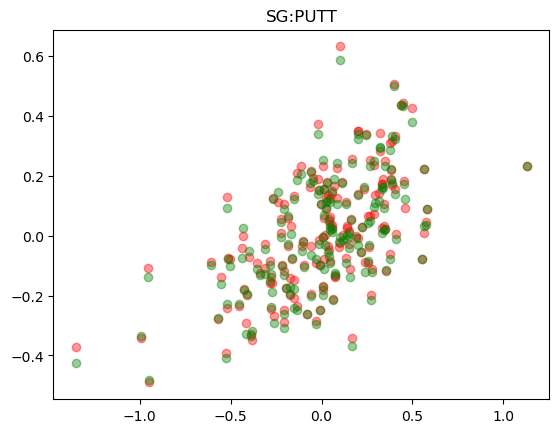

SVR score:  0.6634700680244227
Lin score:  0.6667187502250829
threshold:  0.16691659241104898
% obs w/in one threshold of mean 0.40119760479041916
SVR predictions off by at most one threshold 0.6107784431137725
SVR predictions off by at most one threshold 0.6047904191616766


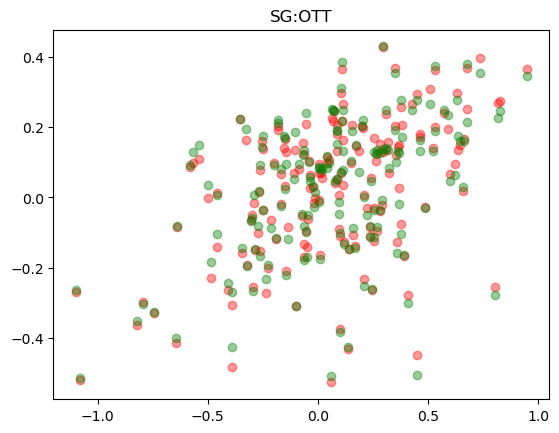

SVR score:  0.7061533153887993
Lin score:  0.7112119650305564
threshold:  0.18352509707701142
% obs w/in one threshold of mean 0.39520958083832336
SVR predictions off by at most one threshold 0.6467065868263473
SVR predictions off by at most one threshold 0.6407185628742516


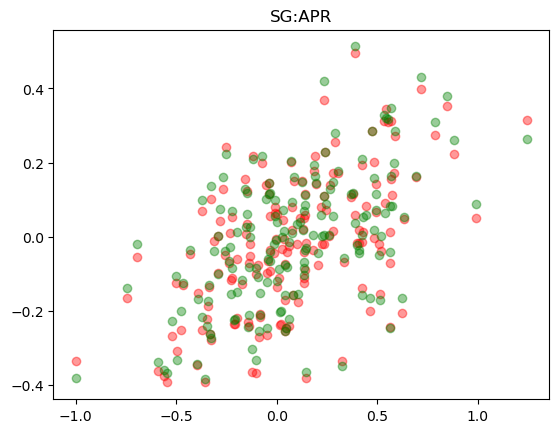

SVR score:  0.7420126411353456
Lin score:  0.748704034118453
threshold:  0.1812830753494483
% obs w/in one threshold of mean 0.40119760479041916
SVR predictions off by at most one threshold 0.6586826347305389
SVR predictions off by at most one threshold 0.688622754491018


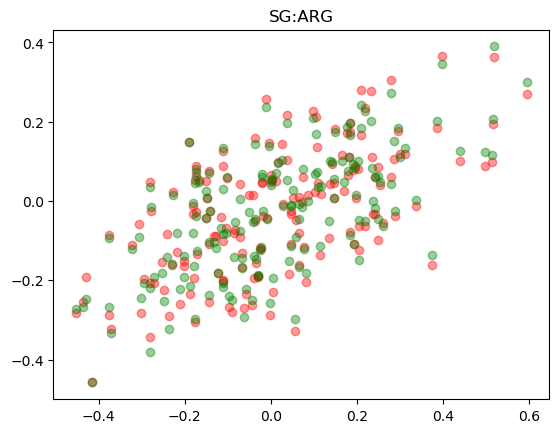

SVR score:  0.4330590821607144
Lin score:  0.4507463076201018
threshold:  0.105678178819356
% obs w/in one threshold of mean 0.3473053892215569
SVR predictions off by at most one threshold 0.49700598802395207
SVR predictions off by at most one threshold 0.49101796407185627


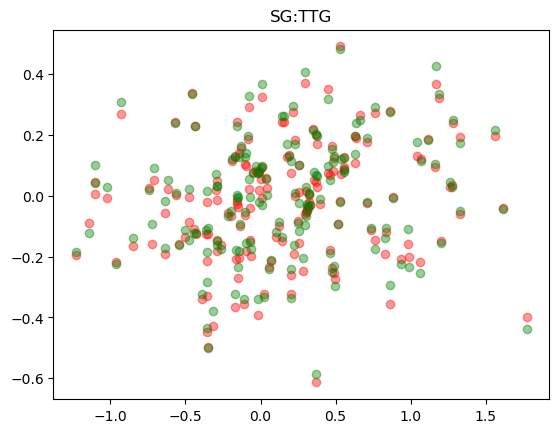

SVR score:  0.8900741206448497
Lin score:  0.8902657077044044
threshold:  0.29089333255093003
% obs w/in one threshold of mean 0.3772455089820359
SVR predictions off by at most one threshold 0.8802395209580839
SVR predictions off by at most one threshold 0.8562874251497006


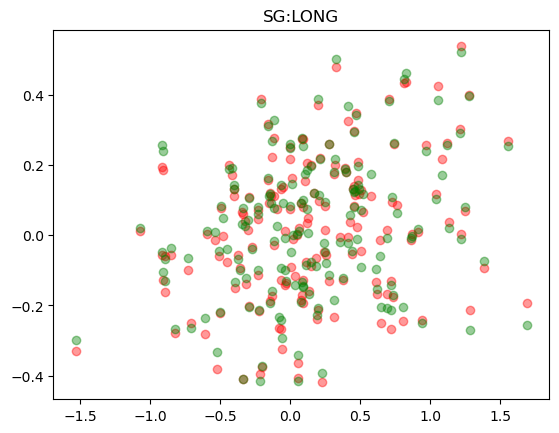

SVR score:  0.8721661483088115
Lin score:  0.8746028613425322
threshold:  0.28185131402651514
% obs w/in one threshold of mean 0.41916167664670656
SVR predictions off by at most one threshold 0.8622754491017964
SVR predictions off by at most one threshold 0.8562874251497006


In [30]:
def svr_lin_regs(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=62)
    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    svr=SVR(kernel='linear',C=.4,epsilon=.2)
    lin=LinearRegression()
    svr.fit(X_train_scaled,y_train)
    lin.fit(X_train_scaled,y_train)
    y_pred_svr=svr.predict(X_test_scaled)
    y_pred_lin=lin.predict(X_test_scaled)
    residuals_svr=(y_test-y_pred_svr)
    residuals_lin=(y_test-y_pred_lin)
    plt.scatter(x=y_test,y=residuals_svr,color='red',alpha=.4)
    plt.scatter(x=y_test,y=residuals_lin,color='green',alpha=.4)
    plt.show()
    print('SVR score: ',svr.score(X_test_scaled,y_test))
    print('Lin score: ',lin.score(X_test_scaled,y_test))
    threshold=y_test.std()/2
    print('threshold: ',threshold)
    print('% obs w/in one threshold of mean', (abs(y_test)<threshold).sum()/len(residuals_svr))
    print('SVR predictions off by at most one threshold',(abs(residuals_svr)<threshold).sum()/len(residuals_svr))
    print('SVR predictions off by at most one threshold',(abs(residuals_lin)<threshold).sum()/len(residuals_lin))
    
for i in range(len(yvars)):
    target=yvars[i] 
    plt.title(target)
    svr_lin_regs(pga_full.drop(nonvars+yvars,axis=1).values,pga_full[target].values)

Ultimately, we see that again the linear and SVR methods are basically doing the same thing, and that makes sense because the linear SVR we've performed is still producing a linear predictor function and just evaluating against a different loss function than standard linear regression. The addition of all the extra features was largely unehlpful with the exception of the Approach category, where I believe the addition of proximity and Par 4 scoring average. Putting may also have been helped by the proximity stat, though interestingly the Around the Green category actually performed a little worse with all the new features. 